<a href="https://colab.research.google.com/github/DrAlexSanz/MC-calculations/blob/main/Monte_Carlo_SP500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
from pandas_datareader import data as wb
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm



# Download SP500 data 

First of all, download all the data since 1980. It goes back to 1927 or so but I'll restrict it to 1980. Maybe I'll do a run with the full data later.

In [33]:
data = pd.DataFrame()

ticker = "^GSPC" #This is the ticker of the SP500 according to Yahoo Finance.
start_dt = "1980-01-01"
end_dt = "2020-12-31"

data = wb.DataReader(ticker, start = start_dt, end = end_dt, data_source = "yahoo") #The date is the index

# Now I have the full data, let's keep the adjusted close and see the time limits
data = data[["Adj Close"]]

data.reset_index(inplace = True) # I don't like to have the date as an index, I want normal index and date as a column
print(data.head())


        Date   Adj Close
0 1980-01-02  105.760002
1 1980-01-03  105.220001
2 1980-01-04  106.519997
3 1980-01-07  106.809998
4 1980-01-08  108.949997


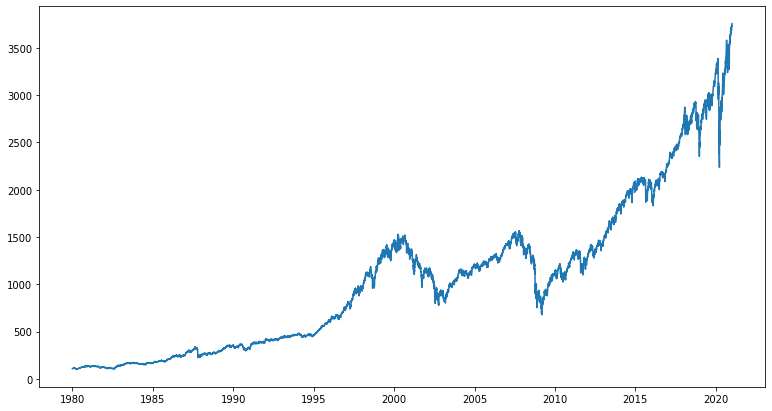

In [34]:
plt.figure(figsize = (13, 7))
plt.plot(data["Date"], data["Adj Close"])
plt.show()

With this I can calculate the CAGR manually, see what happened.

The formula is:

$$
  C = C_0 \cdot (1 + x)^n
$$

And I solve for x when n is 40 periods (1980 to 2020). It should be close to 8-10%

In [35]:
C_0 = data.iloc[1]["Adj Close"]
C = data.iloc[-1]["Adj Close"]

x = (C/C_0)**(1/40) - 1

print(round(x, 2))

0.09


And it is 9% without taking inflation into account. Not bad!

## Now what I want to do is to start the Montecarlo part.

I am going to do it using daily returns and iterating daily. I will do the yearly version later.

In [36]:
day_return = data["Adj Close"].pct_change() # And this is a Series

day_return # Obviously the first one is NaN. There is no % growth before the first day.

0             NaN
1       -0.005106
2        0.012355
3        0.002723
4        0.020036
           ...   
10335    0.003537
10336    0.008723
10337   -0.002227
10338    0.001342
10339    0.006439
Name: Adj Close, Length: 10340, dtype: float64

First, let's check the basic info and see if I have nulls

In [37]:
day_return.describe()

count    10339.000000
mean         0.000410
std          0.011313
min         -0.204669
25%         -0.004496
50%          0.000575
75%          0.005689
max          0.115800
Name: Adj Close, dtype: float64

In [38]:
#Looks like I have Nulls

print(np.isnan(day_return).value_counts())
day_return = day_return.dropna()

False    10339
True         1
Name: Adj Close, dtype: int64


Text(0.5, 1.0, 'Distribution of daily returns')

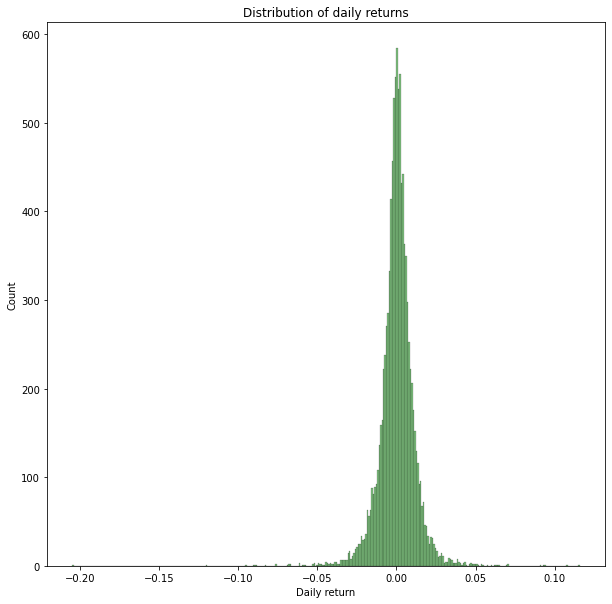

In [39]:
#mu, std = norm.fit(day_return)

#print("The daily returns follow a Normal distribution with \mu = {mu:.3f} and standard deviation = {std:.3f}")

plt.figure(figsize = (10, 10))
sns.histplot(day_return, color = "green", alpha = 0.5)
plt.xlabel("Daily return")
plt.ylabel("Count")
plt.title("Distribution of daily returns") # Being more than 10,000 days I expect a fairly Normal distribution

I can fit it to a Normal distribution because now sns.histplot doesn't do it.

In [40]:
mu, std = norm.fit(day_return)
print(mu, std)

0.00040976599455143863 0.01131231818950601


The daily returns will have a small average and a std fairly larger. It's not usual to have a big daily return, yearly it's compounding but not every day.

## Log returns.

I don't want to use returns in general, but mostly the log of the returns. According to literature this is a good idea for several reasons. See [Explanation of why log returns.](https://quantivity.wordpress.com/2011/02/21/why-log-returns/)

Especially I want to use log(1 + x) because it's normal and fulfills all the assumptions.

Text(0.5, 1.0, 'Distribution of daily returns')

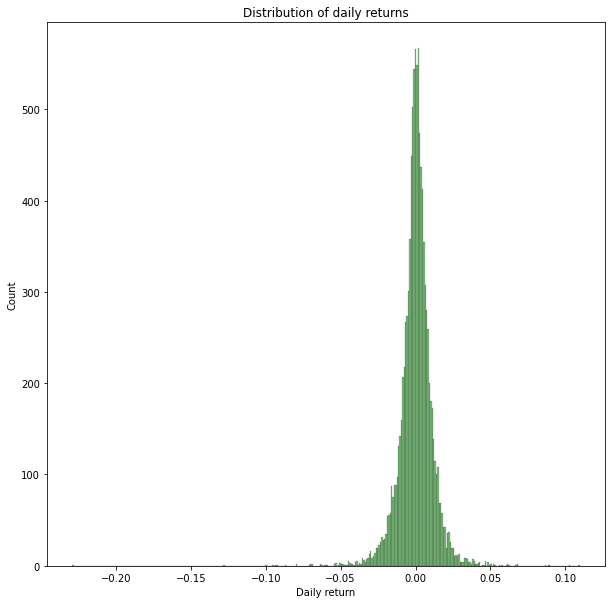

In [41]:
log_ret = np.log(1 + day_return)

plt.figure(figsize = (10, 10))
sns.histplot(log_ret, color = "green", alpha = 0.5)
plt.xlabel("Daily return")
plt.ylabel("Count")
plt.title("Distribution of daily returns") # Being more than 10,000 days I expect a fairly Normal distribution

So the plot looks the same but how about the $\mu$ and $\sigma$?

They will be the same because of the following sorcery:

$$ln(1 + x) \approx x; \space \forall x << 1$$

This is the Taylor (MacLaurin) series:

$$ln(1 + x) = x - \frac{x^2}{2} + \frac{x^3}{3} - \frac{x^4}{4} + ...$$

And I can neglect the higher order terms. When I'm doing the daily returns it doesn't really matter but when I will do the yearly version it will.

In [42]:
mu_log, std_log = norm.fit(day_return)
print(mu_log, std_log)

0.00040976599455143863 0.01131231818950601


Anyway, let's go into the equations

$$Drift = \mu - \frac{\sigma^2}{2}$$

$$Volatility = \sigma \cdot \mathcal{N(0, 1)}$$

$$r = Drift - Volatility $$

$$S_t = S_{t-1}\cdot e^{(\mu - \frac{\sigma}{2}) + \sigma \cdot \mathcal{N(0, 1)}}$$

The $\frac{1}{2}$ in the Drift is because past returns are eroded in the future. The volatility is the historical volatility multiplied by a Normal distribution. Like Gaussian beams in LHC.

In [60]:
u = day_return.mean()
var = day_return.var()

stdev = day_return.std()

days = 60
iterations = 100

drift = u - 0.5 * var**2

random_returns = norm.ppf(np.random.rand(days, iterations))

future_returns = np.exp(drift + stdev * random_returns)

# And now generate the curves

curves = np.zeros_like(future_returns)

curves[0, :] = data.iloc[-1]["Adj Close"]

for t in range(1, iterations):
    curves[t] = curves[t-1] * future_returns[t]



IndexError: ignored

In [58]:
curves

array([[3756.07006836, 3756.07006836, 3756.07006836, ..., 3756.07006836,
        3756.07006836, 3756.07006836],
       [3721.45114338, 3778.42474547, 3764.55178387, ..., 3772.27950205,
        3757.54499581, 3749.58931953],
       [3719.47268222, 3736.9373428 , 3788.2509641 , ..., 3762.04928286,
        3825.17316343, 3740.01395186],
       ...,
       [3891.01818081, 3858.67327397, 4807.0313498 , ..., 4282.78752499,
        3860.89380216, 3416.61921132],
       [3841.51449152, 3901.00674136, 4754.40341686, ..., 4327.15907513,
        3820.39317279, 3433.65268695],
       [3845.84853007, 3866.62698979, 4787.67020466, ..., 4310.63376324,
        3829.19843111, 3417.50731991]])